# Part I: Detection

### 1 - Exploratory data analysis and feature selection

##### Importing the dataset

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
kepler_tab = pd.read_csv('cumulative.csv')
kepler_tab.head()
import warnings
warnings.filterwarnings("ignore") #This has been added once the warnings have been verified

##### Variables to be dropped from the feature list due to the following reasons

In [2]:
# The following variables cannot be considered as features
not_features = ['rowid', #Index of the dataset
                'kepid', #Kepler Identification 
                'kepoi_name', #KOI Name
                'kepler_name', #Kepler Name
                'koi_disposition', #Target (Exoplanet Archive Disposition)
                'koi_pdisposition', #Disposition Using Kepler Data
                'koi_score', # As explained in the proposal, the koi score will be used as a challenger for the models
                'koi_bin_oedp_sig', # This variable is not explained anywhere, thus we remove it by precaution
                'koi_comment', # Description for False positive classification
                'koi_datalink_dvr', # Path to documentation
                'koi_datalink_dvs', # Path to documentation
                'koi_time0bk', # Transit Epoch 
                'koi_time0bk_err1',
                'koi_time0bk_err2',
                'koi_time0', # Transit Epoch in BJD
                'koi_time0_err1',
                'koi_time0_err2',
                'koi_tce_plnt_num', # TCE Planet Number
                'koi_quarters'] #Quarters

In [3]:
# The following variables have missing value for all data points
null_variables = []
for i in kepler_tab.columns:
    if kepler_tab[i].notnull().sum() == 0:
        null_variables.append(i)

In [4]:
# The following variables have the same value for all data points
unique_value = []
for i in kepler_tab.columns:
    if kepler_tab[i].value_counts().count() == 1:
        unique_value.append(i)

In [5]:
# The following variables are referring to aquisition of the data
aquisition = ['koi_fittype', #Planetary Fit Type
              'koi_sparprov', #Source of stellar parameter
              'koi_parm_prov', # Table provenence as it's a cumulative table
              'koi_tce_delivname'] # TCE delivery name

##### Correcting wrong values

In [6]:
# We define here a first list of variables to be dropped based on the previous step of exploratory data analysis
drop_step1 = not_features + null_variables + unique_value + aquisition
box = kepler_tab.drop(drop_step1,axis=1)

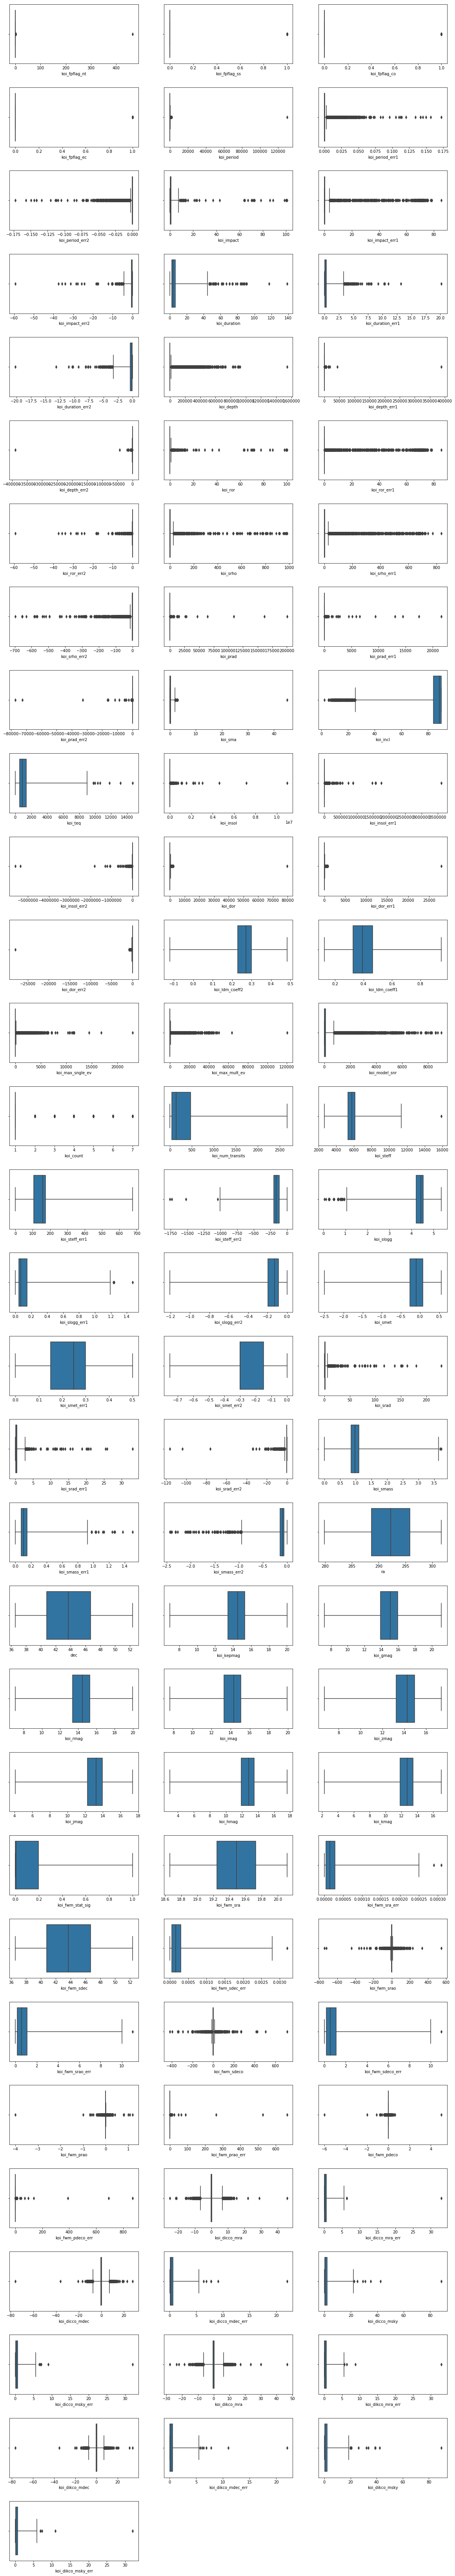

In [7]:
f = plt.figure(figsize=(20, 120))
i=1
import math
for col in box.columns:
    subplot = f.add_subplot(math.ceil(box.shape[1]/3),3,i)
    sns.boxplot(x=box[col].dropna(),whis=10)
    i=i+1
plt.subplots_adjust(hspace=0.4)
plt.show()

In [8]:
print('koi_fpflag_nt shows value {} that is out of range, as it should be either 0 or 1'.format(box['koi_fpflag_nt'].max()))
print('The median value for koi_fpflag_nt is {:.0f}, then the wrong value is replaced by {:.0f}'
      .format(box['koi_fpflag_nt'].median(),box['koi_fpflag_nt'].median()))
box.koi_fpflag_nt[np.argmax(box['koi_fpflag_nt'])] = box['koi_fpflag_nt'].median()

koi_fpflag_nt shows value 465 that is out of range, as it should be either 0 or 1
The median value for koi_fpflag_nt is 0, then the wrong value is replaced by 0


In [9]:
print('koi_period shows value {} that is very high compared to the rest of the values.'.format(box['koi_period'].max()))
print('This values means that the koi takes {:.0f} days = {:.0f} years to turn around its star (comparatively 1 year for the earth).'
      .format(box['koi_period'].max(),box['koi_period'].max()/365))
print('Even this is a very high period, it\'s not impossible, additionally it\'s correlated with the high values of koi_sma (Orbit Semi-Major Axis (Astronomical Unit (AU)) and the koi_dor (Planet-Star Distance over Star Radius) :')
print('koi_sma of planet with the highest koi_period = {}'.format(box.koi_sma[np.argmax(box['koi_period'])]))
print('Highest koi_sma in the dataset = {}'.format(box['koi_sma'].max()))
print('koi_dor of planet with the highest koi_period = {}'.format(box.koi_dor[np.argmax(box['koi_period'])]))
print('Highest koi_dor in the dataset = {}'.format(box['koi_dor'].max()))
print()
print('We can consider this koi as an outlier, but it won\'t affect the modeling since it\'s a {}'
      .format(kepler_tab.koi_disposition[np.argmax(box['koi_period'])]))
print()
second = box['koi_period'].sort_values(ascending=False).head(2)
second.index = [0,1]
print('Something interesting to notice also is that the second largest period for all koi is {} ({:.0f} years) which is lower than the mission duration (2009 to 2018).'
      .format(second[1],second[1]/365))
print('This confirm the limitation of the transit method to detect planets that are far from their star, and then have a period loger than the possible observation. If this koi with the highest period is confirmed to be a planet, it has been a happy luck to detect its transit.')

koi_period shows value 129995.7784 that is very high compared to the rest of the values.
This values means that the koi takes 129996 days = 356 years to turn around its star (comparatively 1 year for the earth).
Even this is a very high period, it's not impossible, additionally it's correlated with the high values of koi_sma (Orbit Semi-Major Axis (Astronomical Unit (AU)) and the koi_dor (Planet-Star Distance over Star Radius) :
koi_sma of planet with the highest koi_period = 44.9892
Highest koi_sma in the dataset = 44.9892
koi_dor of planet with the highest koi_period = 79614.0
Highest koi_dor in the dataset = 79614.0

We can consider this koi as an outlier, but it won't affect the modeling since it's a CANDIDATE

Something interesting to notice also is that the second largest period for all koi is 2190.7010353 (6 years) which is lower than the mission duration (2009 to 2018).
This confirm the limitation of the transit method to detect planets that are far from their star, and then ha

In [10]:
print('koi_depth shows value {} that is out of range, as the max value should be 1000000'.format(box['koi_depth'].max()))
print('The median value for koi_depth is {}, then the wrong value is replaced by {}'
      .format(box['koi_depth'].median(),box['koi_depth'].median()))
print('The error measurement values of koi_depth for the same data point are respectively {} and {}, which correspond to the outliers observed in the previous boxplots'
     .format(box.koi_depth_err1[np.argmax(box['koi_depth'])],box.koi_depth_err2[np.argmax(box['koi_depth'])]))
print('This implies that there has been a measurement issue for this datapoint related to the depth, this also error margin value of the depth are replaced by the median values for this data point')
box.koi_depth_err1[np.argmax(box['koi_depth'])] = box['koi_depth_err1'].median()
box.koi_depth_err2[np.argmax(box['koi_depth'])] = box['koi_depth_err2'].median()
box.koi_depth[np.argmax(box['koi_depth'])] = box['koi_depth'].median()

koi_depth shows value 1541400.0 that is out of range, as the max value should be 1000000
The median value for koi_depth is 421.1, then the wrong value is replaced by 421.1
The error measurement values of koi_depth for the same data point are respectively 388600.0 and -388600.0, which correspond to the outliers observed in the previous boxplots
This implies that there has been a measurement issue for this datapoint related to the depth, this also error margin value of the depth are replaced by the median values for this data point


##### Categorical variables on which we will apply one-hot encoding

There is no categorical variables in the remaining ones after step 1 drop

##### Missing values

The purpose of this part is to check weather we can group the data points accordingly to an aquisition parameter that affect the number of missing values

In [11]:
# List of variables with at least 1 missing value
list_null_values = pd.DataFrame({'Variable':[],'nb_empty':[]})
for i in kepler_tab.drop(drop_step1,axis=1).columns:
    if kepler_tab[i].isnull().sum() > 0:
        list_null_values=pd.concat([list_null_values,pd.DataFrame({'Variable':[i],'nb_empty':[kepler_tab[i].isnull().sum()]})])
list_null_values.sort_values('nb_empty',ascending=False,inplace=True)
list_null_values.reset_index(inplace=True, drop=True)
list1 = list_null_values
print('There is {} variables with at least 1 missing value over the total of remaining {} variables after step 1 filtering'.
      format(list_null_values.shape[0],kepler_tab.drop(drop_step1,axis=1).shape[1]))

There is 82 variables with at least 1 missing value over the total of remaining 91 variables after step 1 filtering


Lets have a look at each of these variables and how many missing values they have, compared to the values of aquisition parameters

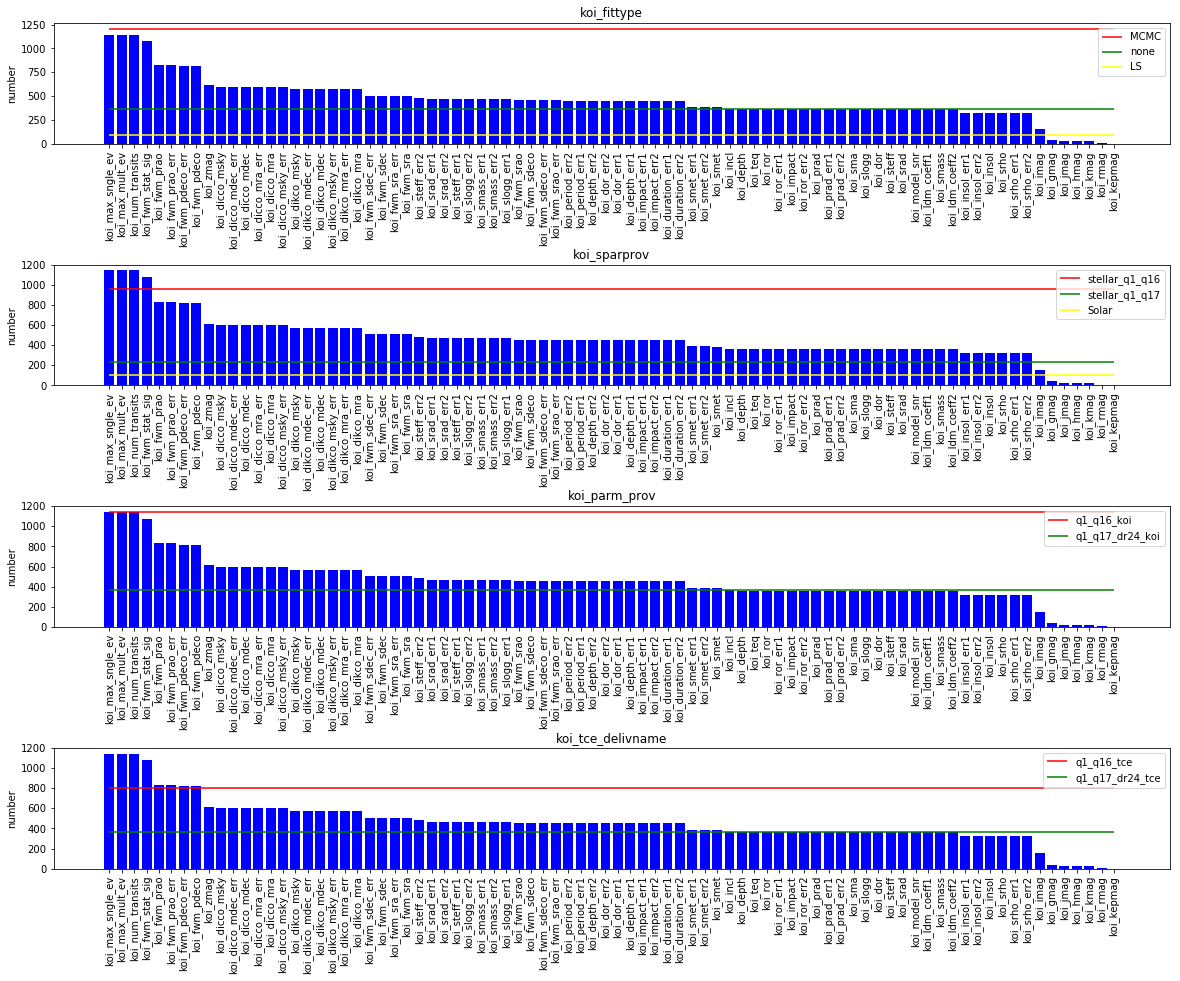

In [12]:
colors = ['grey','red','green','yellow']
f=plt.figure(figsize=(20,20))
for i in range(len(aquisition)):
    aqu_var_val = kepler_tab[aquisition[i]]
    subplot = f.add_subplot(len(aquisition)+1,1,i+1)
    for j in range(aqu_var_val.value_counts().index.size):
        if (aqu_var_val.value_counts()[j]!=aqu_var_val.value_counts().max()) & (aqu_var_val.value_counts()[j]>=9):
            #This is because we previously noticed that the 
            #highest number is much higher than the others and does not correspond to any empty number
            plt.bar(list_null_values.index, list_null_values.nb_empty,color='blue')
            plt.hlines(aqu_var_val.value_counts()[j], list_null_values.index.min(), list_null_values.index.max(), 
                       linestyles='solid', color=colors[j],label=aqu_var_val.value_counts().index[j])
            plt.xticks(list_null_values.index, list_null_values.Variable, rotation=90)
    plt.ylabel('number')
    plt.title(aquisition[i])
    plt.legend()
plt.subplots_adjust(hspace=1)
plt.show()

It looks to be a an impact of (koi_fittype = none) on a certain number of empty values. To verify this, we are going to remove all data points with this value and check what are the remaining empty values

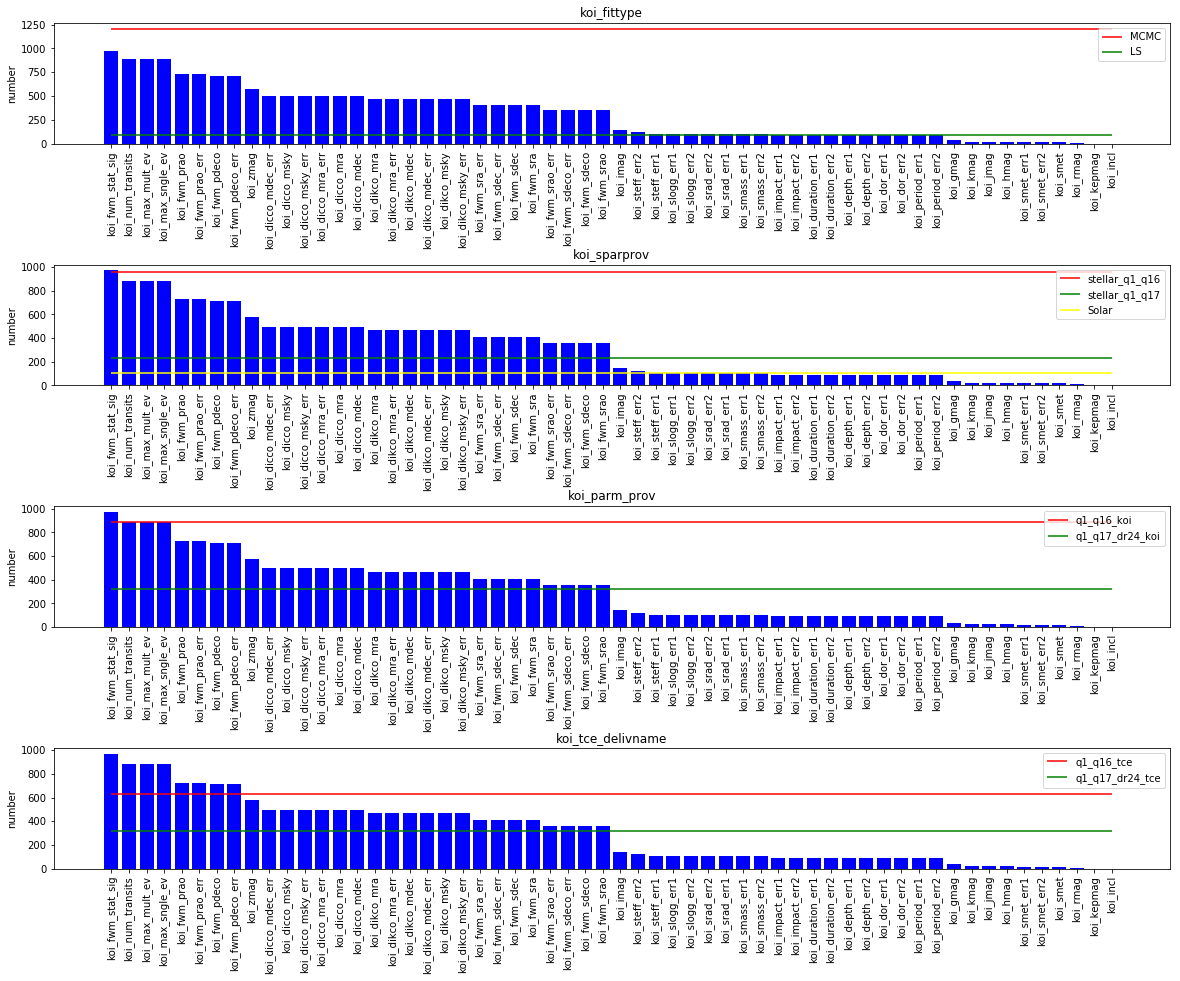

In [13]:
filters = kepler_tab[kepler_tab.koi_fittype != 'none']
list_null_values = pd.DataFrame({'Variable':[],'nb_empty':[]})
for i in filters.drop(drop_step1,axis=1).columns:
    if filters[i].isnull().sum() > 0:
        list_null_values=pd.concat([list_null_values,pd.DataFrame({'Variable':[i],'nb_empty':[filters[i].isnull().sum()]})])
list_null_values.sort_values('nb_empty',ascending=False,inplace=True)
list_null_values.reset_index(inplace=True, drop=True)
list2 = list_null_values
f=plt.figure(figsize=(20,20))
for i in range(len(aquisition)):
    aqu_var_val = filters[aquisition[i]]
    subplot = f.add_subplot(len(aquisition)+1,1,i+1)
    for j in range(aqu_var_val.value_counts().index.size):
        if (aqu_var_val.value_counts()[j]!=aqu_var_val.value_counts().max()) & (aqu_var_val.value_counts()[j]>=9):
            #This is because we previously noticed that the 
            #highest number is much higher than the others and does not correspond to any empty number
            plt.bar(list_null_values.index, list_null_values.nb_empty,color='blue')
            plt.hlines(aqu_var_val.value_counts()[j], list_null_values.index.min(), list_null_values.index.max(), 
                       linestyles='solid', color=colors[j],label=aqu_var_val.value_counts().index[j])
            plt.xticks(list_null_values.index, list_null_values.Variable, rotation=90)
    plt.ylabel('number')
    plt.title(aquisition[i])
    plt.legend()
plt.subplots_adjust(hspace=1)
plt.show()

In [14]:
list_null_values.shape

(58, 2)

The number of variables with empty values has been decreased from 82 to 58. We can now observe that (koi_fittype = LS) has an impact on a certain number of empty values. We do the same than previously by removing all data points with this value and check what are the remaining mpty values

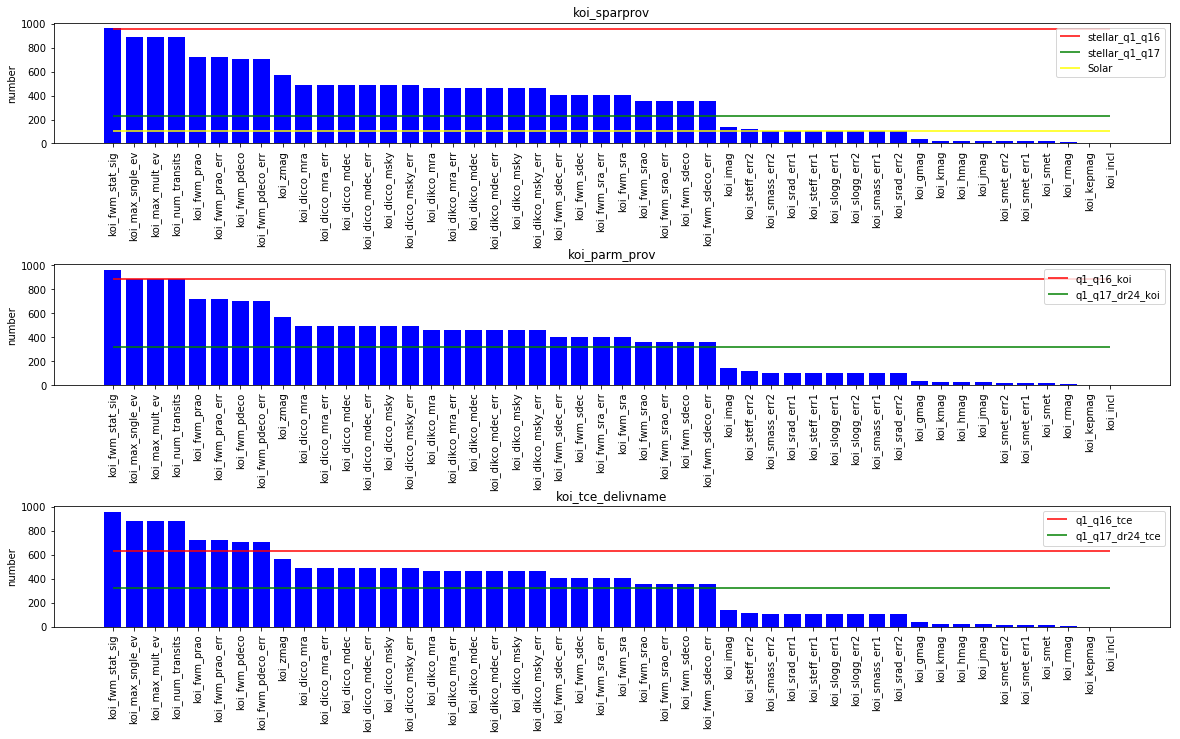

In [15]:
filters = kepler_tab[(kepler_tab.koi_fittype != 'none') & (kepler_tab.koi_fittype != 'LS')]
list_null_values = pd.DataFrame({'Variable':[],'nb_empty':[]})
for i in filters.drop(drop_step1,axis=1).columns:
    if filters[i].isnull().sum() > 0:
        list_null_values=pd.concat([list_null_values,pd.DataFrame({'Variable':[i],'nb_empty':[filters[i].isnull().sum()]})])
list_null_values.sort_values('nb_empty',ascending=False,inplace=True)
list_null_values.reset_index(inplace=True, drop=True)
list3 = list_null_values
f=plt.figure(figsize=(20,20))
for i in range(1,len(aquisition)):
    aqu_var_val = filters[aquisition[i]]
    subplot = f.add_subplot(len(aquisition)+1,1,i)
    for j in range(aqu_var_val.value_counts().index.size):
        if (aqu_var_val.value_counts()[j]!=aqu_var_val.value_counts().max()) & (aqu_var_val.value_counts()[j]>=9):
            #This is because we previously noticed that the 
            #highest number is much higher than the others and does not correspond to any empty number
            plt.bar(list_null_values.index, list_null_values.nb_empty,color='blue')
            plt.hlines(aqu_var_val.value_counts()[j], list_null_values.index.min(), list_null_values.index.max(), 
                       linestyles='solid', color=colors[j],label=aqu_var_val.value_counts().index[j])
            plt.xticks(list_null_values.index, list_null_values.Variable, rotation=90)
    plt.ylabel('number')
    plt.title(aquisition[i])
    plt.legend()
plt.subplots_adjust(hspace=1)
plt.show()

In [16]:
list_null_values.shape

(48, 2)

Now the number of variables with empty values has been decreased from 58 to 48. No more filtering can be done with koi_fittype. We can therefore observe that (koi_sparprov = Solar) has an impact on a certain number of empty values. We do the same than previously by removing all data points with this value and check what are the remaining mpty values

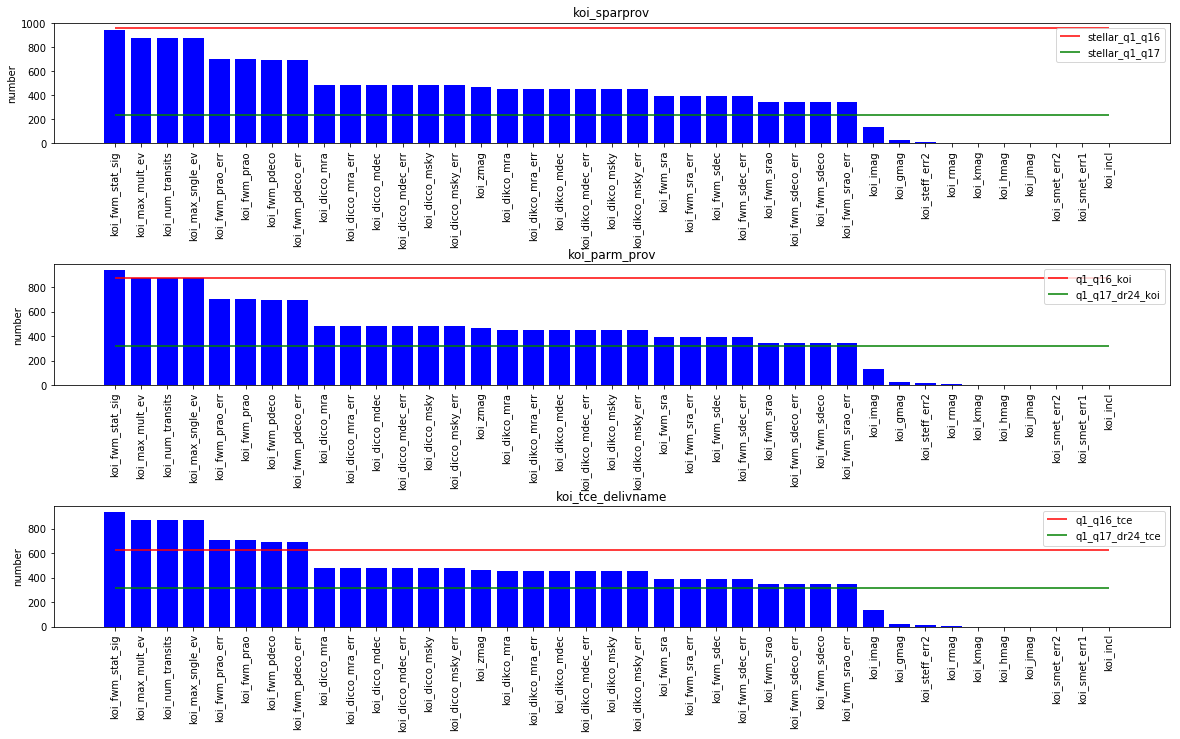

In [17]:
filters = kepler_tab[(kepler_tab.koi_fittype != 'none') & (kepler_tab.koi_fittype != 'LS') 
                                  & (kepler_tab.koi_sparprov != 'Solar')]
list_null_values = pd.DataFrame({'Variable':[],'nb_empty':[]})
for i in filters.drop(drop_step1,axis=1).columns:
    if filters[i].isnull().sum() > 0:
        list_null_values=pd.concat([list_null_values,
                                    pd.DataFrame({'Variable':[i],'nb_empty':[filters[i].isnull().sum()]})])
list_null_values.sort_values('nb_empty',ascending=False,inplace=True)
list_null_values.reset_index(inplace=True, drop=True)
list4 = list_null_values
f=plt.figure(figsize=(20,20))
for i in range(1,len(aquisition)):
    aqu_var_val = filters[aquisition[i]]
    subplot = f.add_subplot(len(aquisition)+1,1,i)
    for j in range(aqu_var_val.value_counts().index.size):
        if (aqu_var_val.value_counts()[j]!=aqu_var_val.value_counts().max()) & (aqu_var_val.value_counts()[j]>=9):
            #This is because we previously noticed that the 
            #highest number is much higher than the others and does not correspond to any empty number
            plt.bar(list_null_values.index, list_null_values.nb_empty,color='blue')
            plt.hlines(aqu_var_val.value_counts()[j], list_null_values.index.min(), list_null_values.index.max(), 
                       linestyles='solid', color=colors[j],label=aqu_var_val.value_counts().index[j])
            plt.xticks(list_null_values.index, list_null_values.Variable, rotation=90)
    plt.ylabel('number')
    plt.title(aquisition[i])
    plt.legend()
plt.subplots_adjust(hspace=1)
plt.show()

In [18]:
list_null_values.shape

(39, 2)

Now the number of variables with empty values has been decreased from 48 to 39. We can observe that (koi_parm_prov = q1_q16_koi) has an impact on a certain number of empty values. We do the same than previously by removing all data points with this value and check what are the remaining mpty values

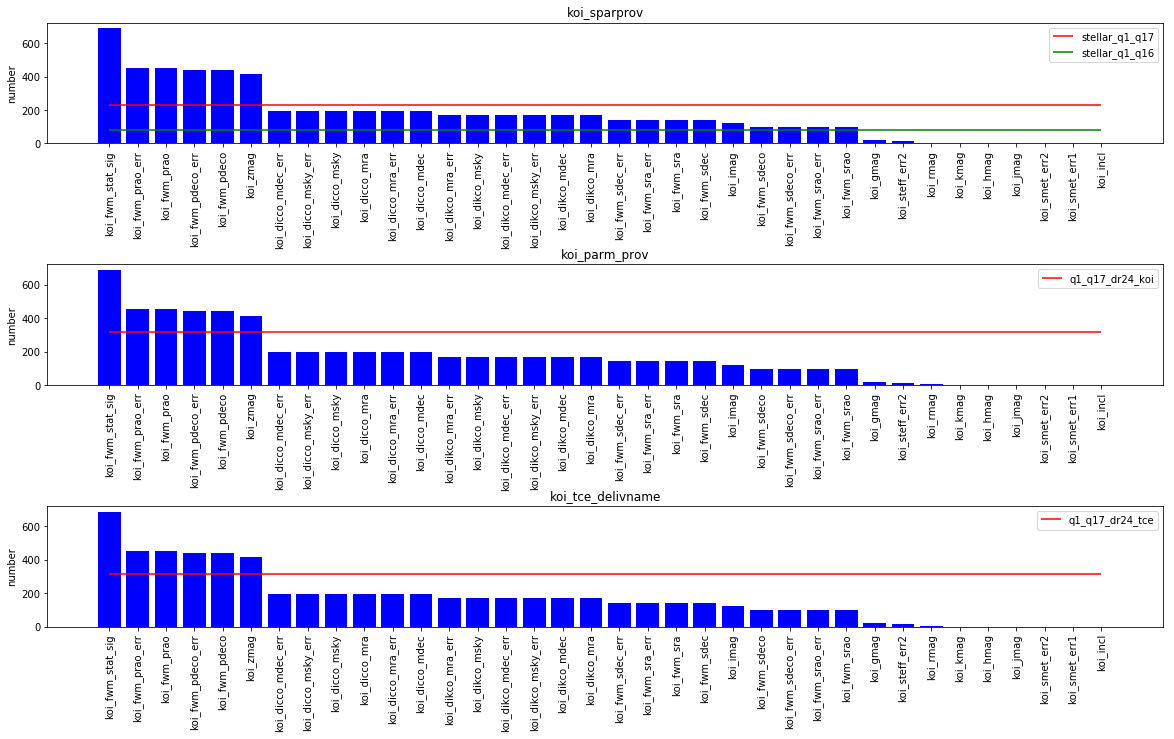

In [19]:
filters = kepler_tab[(kepler_tab.koi_fittype != 'none') & (kepler_tab.koi_fittype != 'LS') 
                                  & (kepler_tab.koi_sparprov != 'Solar') & (kepler_tab.koi_parm_prov != 'q1_q16_koi')]
list_null_values = pd.DataFrame({'Variable':[],'nb_empty':[]})
for i in filters.drop(drop_step1,axis=1).columns:
    if filters[i].isnull().sum() > 0:
        list_null_values=pd.concat([list_null_values,
                                    pd.DataFrame({'Variable':[i],'nb_empty':[filters[i].isnull().sum()]})])
list_null_values.sort_values('nb_empty',ascending=False,inplace=True)
list_null_values.reset_index(inplace=True, drop=True)
list5 = list_null_values
f=plt.figure(figsize=(20,20))
for i in range(1,len(aquisition)):
    aqu_var_val = filters[aquisition[i]]
    subplot = f.add_subplot(len(aquisition)+1,1,i)
    for j in range(aqu_var_val.value_counts().index.size):
        if (aqu_var_val.value_counts()[j]!=aqu_var_val.value_counts().max()) & (aqu_var_val.value_counts()[j]>=9):
            #This is because we previously noticed that the 
            #highest number is much higher than the others and does not correspond to any empty number
            plt.bar(list_null_values.index, list_null_values.nb_empty,color='blue')
            plt.hlines(aqu_var_val.value_counts()[j], list_null_values.index.min(), list_null_values.index.max(), 
                       linestyles='solid', color=colors[j],label=aqu_var_val.value_counts().index[j])
            plt.xticks(list_null_values.index, list_null_values.Variable, rotation=90)
    plt.ylabel('number')
    plt.title(aquisition[i])
    plt.legend()
plt.subplots_adjust(hspace=1)
plt.show()

In [20]:
list_null_values.shape

(36, 2)

Now the number of variables with empty values has been decreased from 39 to 36. The remaining emty values are not related to any of the known aquisition types. The grouping depending on the aquisition variables values can be seen in the folloing table :

In [21]:
merged = pd.merge(list1,list2,on=['Variable'],how='outer')
merged = pd.merge(merged,list3,on=['Variable'],how='outer')
merged = pd.merge(merged,list4,on=['Variable'],how='outer')
merged = pd.merge(merged,list5,on=['Variable'],how='outer')
merged[merged.nb_empty.isnull()]

,Variable,nb_empty_x,nb_empty_y,nb_empty_x,nb_empty_y,nb_empty
0,koi_max_sngle_ev,1142.0,886.0,886.0,873.0,NaN
1,koi_max_mult_ev,1142.0,886.0,886.0,873.0,NaN
2,koi_num_transits,1142.0,886.0,886.0,873.0,NaN
26,koi_srad_err1,468.0,105.0,103.0,NaN,NaN
27,koi_srad_err2,468.0,105.0,103.0,NaN,NaN
28,koi_steff_err1,468.0,105.0,103.0,NaN,NaN
29,koi_slogg_err2,468.0,105.0,103.0,NaN,NaN
30,koi_smass_err1,468.0,105.0,103.0,NaN,NaN
31,koi_smass_err2,468.0,105.0,103.0,NaN,NaN
32,koi_slogg_err1,468.0,105.0,103.0,NaN,NaN


- From the 1st to the 2nd nb_empty columns : (koi_fittype = none) filter leading to the first group where the 2nd column is equal to NaN. Notice that the number of empty values is not exactly the same for all variables (321 and 363) which means there is a subgroup in this first one
- From the 2nd to the 3rd nb_empty columns : (koi_fittype = LS) filter leading to the second group where the 3rd column is equal to NaN. The first group looks to be inclusive in the second one as they have the same amount of decreased empty values after the first filter (363)
- From the 3rd to the 4th nb_empty columns : (koi_sparprov = Solar) filter leading to the third group where the 4th column is equal to NaN. The first group looks to be inclusive in the third one as they have the same amount of decreased empty values after the first filter (363), while the second group is not inclusive in the third one as they don't have the same amount of decreased empty values after applying the second filter (resp. 91 and 2)
- From the 4th to the 5th nb_empty columns : (koi_parm_prov = q1_q16_koi) filter leading to the third group where the 5th column is equal to NaN. None of the previous groups is inclusive in this 4th one as they don't have the same amount of decreased empty values after applying the each of the previous filters
- There is a remaining group of 36 variables that have empty values that are obviously not related to aquisition

Conclusion : Even if some grouping is possible based on the aquisition variables values, it remains quite complex mainly due to inlusion/not inclusion between the different groups. Then I decide to simply remove, in the detection and prediction part, the data points that haveat least 1 empty values for the considered features

##### PCA Analysis

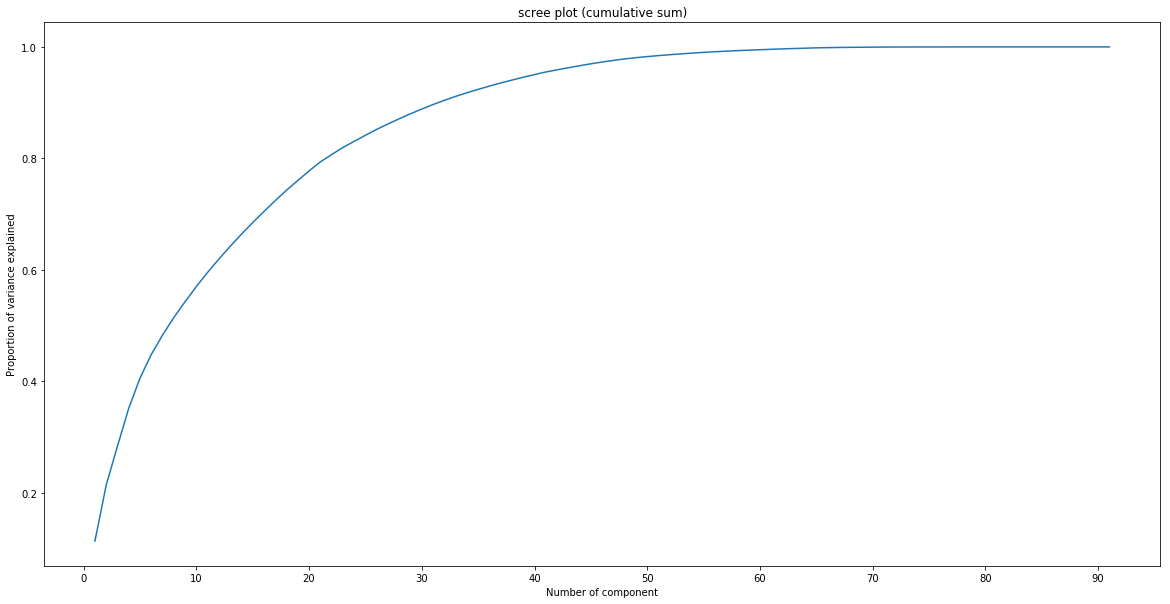

To retain 95% of the variance explained, we should keep 40 components over 91
To retain 99% of the variance explained, we should keep 55 components over 91
To retain 99,99% of the variance explained, we should keep 75 components over 91


In [22]:
drop_step2 = drop_step1 # As no additionnal variables have been excluded in the previous step

# Create the dataframe that will be used in the PCA analysis
pca_df = kepler_tab.drop(drop_step2,axis=1)
pca_df_nn = pca_df[pca_df.isnull().sum(axis=1)==0]

# PVE calculation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
pca_df_rescaled = scaler.fit_transform(pca_df_nn)
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pca.fit(pca_df_rescaled)
pve = pca.explained_variance_ratio_

# Scree plot
x_coor = np.arange(1, pca_df.shape[1]+1)
f = plt.figure(figsize=(20, 10))
pve_cumsum = np.cumsum(pve[0:pca_df.shape[1]]) # Calculate cumulative sum
plt.plot(x_coor,pve_cumsum)
plt.xlabel('Number of component')
plt.ylabel('Proportion of variance explained')
plt.title('scree plot (cumulative sum)')
plt.xticks(np.arange(0, pca_df.shape[1]+1, step=10))
plt.show()

# How many components should we keep to retain 95%, 99% and 99,99% of the variance explained?
print('To retain 95% of the variance explained, we should keep {} components over {}'.
      format(((~(pve_cumsum >= 0.95)).sum())+1,pca_df.shape[1]))
print('To retain 99% of the variance explained, we should keep {} components over {}'.
      format(((~(pve_cumsum >= 0.99)).sum())+1,pca_df.shape[1]))
print('To retain 99,99% of the variance explained, we should keep {} components over {}'.
      format(((~(pve_cumsum >= 0.9999)).sum())+1,pca_df.shape[1]))

##### Features and data points selection

In [23]:
# Variables to drop from the features list
to_drop = drop_step2
X_all = kepler_tab[kepler_tab.koi_disposition != 'CANDIDATE'].drop(to_drop,axis=1)
y_all = kepler_tab[kepler_tab.koi_disposition != 'CANDIDATE'].koi_disposition

# Data points having at least one empty value are dropped
X_nn = X_all[X_all.isnull().sum(axis=1)==0]
y_nn = y_all[X_all.isnull().sum(axis=1)==0]

Let's look at the impact of removing data points with at least one empty value on the data input

In [24]:
# comparing input shapes
print('Input shape before filtering datapoints is ',X_all.shape)
print('Input shape after removing all data points with at least one empty value is ',X_nn.shape)

Input shape before filtering datapoints is  (7140, 91)
Input shape after removing all data points with at least one empty value is  (5127, 91)


We also compare also classes distribution before and after data points filtering

In [25]:
pd.value_counts(y_all, normalize=True)

FALSE POSITIVE    0.678011
CONFIRMED         0.321989
Name: koi_disposition, dtype: float64

In [26]:
pd.value_counts(y_nn, normalize=True)

FALSE POSITIVE    0.592744
CONFIRMED         0.407256
Name: koi_disposition, dtype: float64

By removing data points having at least one empty value, we are loosing ~2000 data points, which is a quite high number, but we are anyway keeping ~5000 data points to train our models, with acceptable share between the 2 classes (40% and 60%) which is even more interesting than the initial dataset (32% and 68%)

In [27]:
# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_nn, y_nn,
    train_size=0.8, test_size=0.2, stratify=y_nn, random_state=1)

# Train/validation split
from sklearn.model_selection import train_test_split
X_tr, X_vl, y_tr, y_vl = train_test_split(
    X_train, y_train, train_size=0.8, test_size=0.2, stratify=y_train, random_state=1)

### 2 - Classification models testing

In [28]:
# The following are commonly used for all, or at least most of the models

#Standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# PCA
from sklearn.decomposition import PCA
pca = PCA()

# Grid search with cross-validation
from sklearn.model_selection import GridSearchCV

# Pipeline
from sklearn.pipeline import Pipeline

#### Logistic regression

In [29]:
%%time
# Logistic regression estimator
from sklearn.linear_model import SGDClassifier
logreg = SGDClassifier(loss='log',max_iter=1000, tol=1e-3, random_state=0)

# Pipeline for Logistic regression
lr_pipe = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('logreg', logreg)
])

# Fit and tune the estimator
lr_gridcv = GridSearchCV(lr_pipe, [{
    'pca': [None],
    'logreg__alpha' :[1e-05,0.0001,0.001,0.01,0.1, 1,10]
},{    
    'pca__n_components': [40, 55, 75],
    'logreg__alpha' :[1e-05,0.0001,0.001,0.01,0.1, 1,10]
}], cv=5)
lr_gridcv.fit(X_train, y_train)

Wall time: 1min 50s


In [30]:
# Sort accuracy for each alpha and number of components value
df = pd.DataFrame.from_items([
    ('n components', lr_gridcv.cv_results_['param_pca__n_components']),
    ('alpha', lr_gridcv.cv_results_['param_logreg__alpha']),
    ('mean accuracy', lr_gridcv.cv_results_['mean_test_score']),
    ('standard deviation', lr_gridcv.cv_results_['std_test_score'])
])
df['n components'].fillna(X_nn.shape[1],inplace=True)
df.sort_values(by='mean accuracy', ascending=False).head()

,n components,alpha,mean accuracy,standard deviation
3,91,0.01,0.990490,0.004524
18,75,0.01,0.990490,0.004524
17,55,0.01,0.989759,0.004538
15,75,0.001,0.988539,0.003144
2,91,0.001,0.988296,0.003668


In [31]:
# Logistic regression accuracy on test set
lr_accuracy = lr_gridcv.score(X_test,y_test)
print('Logistic regression accuracy (test set): {:.4f}'.format(lr_accuracy))

Logistic regression accuracy (test set): 0.9834


#### Decision tree

We start with a simple Descision tree, only optimizing the depth using grid search (without cross validation)

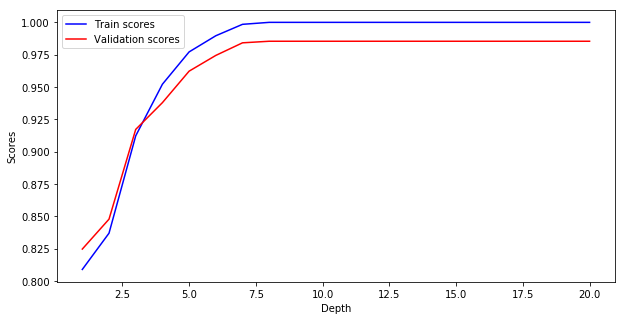

Best accuracy on validation set is :0.99 with depth 8
Decision tree accuracy (test set): 0.9854
Wall time: 6.45 s


In [32]:
%%time
# Creating and tuning Decision tree
from sklearn.tree import DecisionTreeClassifier
depth_values = range(1,21)
train_scores = []
valid_scores = []

for params_dict in depth_values:
    dt = DecisionTreeClassifier(max_depth=params_dict, random_state=0)
    dt.fit(X_tr, y_tr)
    train_scores.append(dt.score(X_tr, y_tr))
    valid_scores.append(dt.score(X_vl, y_vl))
    
# Visualizing tuning
f = plt.figure(figsize=(10, 5))
plt.plot(range(1,21),train_scores,label='Train scores',c='blue')
plt.plot(range(1,21),valid_scores,label='Validation scores',c='red')
plt.xlabel('Depth')
plt.ylabel('Scores')
plt.legend()
plt.show()

depth_opt = np.argmax(valid_scores)+1
print('Best accuracy on validation set is :{:.2f} with depth {}'.format(np.max(valid_scores),depth_opt))

# Decision tree accuracy on test set
dt = DecisionTreeClassifier(criterion='gini', max_depth=depth_opt, random_state=0)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

dt_accuracy = dt.score(X_test, y_test)
print('Decision tree accuracy (test set): {:.4f}'.format(dt_accuracy))

As the accuracy is lower than for logistic regression, and as we saw in the previous project, tuning only the depth brings lowest accuracy compared to the other models. Thus I decided to tune furthermore decision tree using grid search with cross validation to optimize depth, creterion and the number of pca components, and therefore try increase the accuracy.

In [33]:
%%time
# Pipeline
dt_pipe = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('dt1', DecisionTreeClassifier(random_state=0))
])

# Fit and tune the estimator
dt_gridcv = GridSearchCV(dt_pipe, [{
    'pca': [None],
    'dt1__max_depth' :range(1,21),
    'dt1__criterion' :['gini','entropy']
},{
    'pca__n_components': [40, 55, 75],
    'dt1__max_depth' :range(1,21),
    'dt1__criterion' :['gini','entropy']
}], cv=5)
dt_gridcv.fit(X_train, y_train)

# Sort accuracy for each depth and number of components value
df = pd.DataFrame.from_items([
    ('n components', dt_gridcv.cv_results_['param_pca__n_components']),
    ('depth', dt_gridcv.cv_results_['param_dt1__max_depth']),
    ('creterion', dt_gridcv.cv_results_['param_dt1__criterion']),
    ('mean accuracy', dt_gridcv.cv_results_['mean_test_score']),
    ('standard deviation', dt_gridcv.cv_results_['std_test_score'])
])
df['n components'].fillna(X_nn.shape[1],inplace=True)

Wall time: 13min 13s


In [34]:
df.sort_values(by='mean accuracy', ascending=False).head()

,n components,depth,creterion,mean accuracy,standard deviation
26,91,7,entropy,0.994148,0.003396
27,91,8,entropy,0.994148,0.003026
38,91,19,entropy,0.993416,0.002844
39,91,20,entropy,0.993416,0.002844
28,91,9,entropy,0.993416,0.002844


In [35]:
# Decision tree (with further tuning)accuracy on test set
dtgridcv_accuracy = dt_gridcv.score(X_test,y_test)
print('Decision tree (grid search with cross validation) accuracy (test set): {:.4f}'.format(dtgridcv_accuracy))

Decision tree (grid search with cross validation) accuracy (test set): 0.9903


Conclusion : Optimizing more parameters leads to a higher acuracy on the test set and also an accuracy that is aligned with the training. We will then use this model instead of the simple one.

#### Random forest

In [36]:
%%time
# Creating and tuning Random forest
from sklearn.ensemble import RandomForestClassifier
nb_estimators = [5,10,15,20,30,40,50,60,100]
valid_scores = []
for nb in nb_estimators:
    rf = RandomForestClassifier(n_estimators=nb, max_depth=None, random_state=0)
    rf.fit(X_tr, y_tr)
    valid_scores.append(rf.score(X_vl, y_vl))
import pandas as pd
rf_tune = pd.DataFrame({'n estimators':nb_estimators,'validation accuracy':valid_scores})

Wall time: 8.41 s


In [37]:
rf_tune.sort_values(by='validation accuracy', ascending=False)

,n estimators,validation accuracy
2,15,0.991474
3,20,0.990256
5,40,0.990256
7,60,0.987820
8,100,0.987820
4,30,0.986602
6,50,0.986602
0,5,0.984166
1,10,0.984166


In [38]:
# Random forest accuracy on test set
rf = RandomForestClassifier(n_estimators=15, max_depth=None, random_state=0)
rf.fit(X_train, y_train)

rf_accuracy = rf.score(X_test, y_test)
print('Random forest accuracy (test set): {:.4f}'.format(rf_accuracy))

Random forest accuracy (test set): 0.9805


As we did for decision tree, we test random forest using grid search with cross validation to optimize the number of estimators, the creterion and the number of pca components

In [39]:
%%time
# Pipeline
rf_pipe = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('rf1', RandomForestClassifier(max_depth=None, random_state=0))
])

# Fit and tune the estimator
rf_gridcv = GridSearchCV(rf_pipe, [{
    'pca': [None],
    'rf1__n_estimators' :[5,10,15,20,30,40,50,60,100],
    'rf1__criterion' :['gini','entropy']
},{
    'pca__n_components': [40, 55, 75],
    'rf1__n_estimators' :[5,10,15,20,30,40,50,60,100],
    'rf1__criterion' :['gini','entropy']
}], cv=5)
rf_gridcv.fit(X_train, y_train)

# Sort accuracy for each depth and number of components value
df = pd.DataFrame.from_items([
    ('n components', rf_gridcv.cv_results_['param_pca__n_components']),
    ('n estimators', rf_gridcv.cv_results_['param_rf1__n_estimators']),
    ('creterion', rf_gridcv.cv_results_['param_rf1__criterion']),
    ('mean accuracy', rf_gridcv.cv_results_['mean_test_score']),
    ('standard deviation', rf_gridcv.cv_results_['std_test_score'])
])
df['n components'].fillna(X_nn.shape[1],inplace=True)

Wall time: 11min 44s


In [40]:
df.sort_values(by='mean accuracy', ascending=False).head()

,n components,n estimators,creterion,mean accuracy,standard deviation
17,91,100,entropy,0.993172,0.001980
8,91,100,gini,0.992929,0.002820
6,91,50,gini,0.992441,0.003215
16,91,60,entropy,0.992197,0.002260
5,91,40,gini,0.992197,0.002841


In [41]:
# Random forest (with further tuning) accuracy on test set
rfgridcv_accuracy = rf_gridcv.score(X_test,y_test)
print('Random forest (grid search with cross validation) accuracy (test set): {:.4f}'.format(rfgridcv_accuracy))

Random forest (grid search with cross validation) accuracy (test set): 0.9883


Conclusion : It's not worth it to optimize random forest model parameters using grid search with cross validation as both models have the same accuracy and the first one is faster.

#### Support vector machines with linear kernel

In [42]:
%%time
# SVM linear
from sklearn.svm import LinearSVC

# Pipeline
svmlinear_pipe = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('svmlinear', LinearSVC(random_state=0))
])

# Fit and tune the estimator
svmlinear_gridcv = GridSearchCV(svmlinear_pipe, [{
    'pca': [None],
    'svmlinear__C' :[0.0001,0.001,0.01,0.1,1,10,100]
},{
    'pca__n_components': [40,55,75],
    'svmlinear__C' :[0.0001,0.001,0.01,0.1,1,10,100]
}], cv=5)

svmlinear_gridcv.fit(X_train, y_train)

# Sort accuracy for each C value
import pandas as pd
df = pd.DataFrame.from_items([
    ('n components', svmlinear_gridcv.cv_results_['param_pca__n_components']),
    ('C', svmlinear_gridcv.cv_results_['param_svmlinear__C']),
    ('mean accuracy', svmlinear_gridcv.cv_results_['mean_test_score']),
    ('standard deviation', svmlinear_gridcv.cv_results_['std_test_score'])
])
df['n components'].fillna(X_nn.shape[1],inplace=True)

Wall time: 1min 37s


In [43]:
df.sort_values(by='mean accuracy', ascending=False).head()

,n components,C,mean accuracy,standard deviation
24,75,0.1,0.991953,0.004472
3,91,0.1,0.991953,0.004472
17,55,0.1,0.991222,0.006044
18,55,1,0.990734,0.006054
23,75,0.01,0.990490,0.005422


In [44]:
# SVM Linear accuracy
svmlinear_accuracy = svmlinear_gridcv.score(X_test,y_test)
print('Linear SVM accuracy (test set): {:.4f}'.format(svmlinear_accuracy))

Linear SVM accuracy (test set): 0.9825


#### Support vector machines with RBF kernel

In [45]:
%%time
# SVC
from sklearn.svm import SVC # SVC doesn't scale well to a large number of data points
svc = SVC(kernel='rbf')

# Pipeline
from sklearn.pipeline import Pipeline
svmrbf_pipe = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('svc', svc)
])

# Fit and tune the estimator
from sklearn.model_selection import GridSearchCV
svmrbf_gridcv = GridSearchCV(svmrbf_pipe, {'svc__C': [0.01,0.1, 1, 10,100],
                                     'svc__gamma':[1e-05,1e-04,0.001,0.01,0.1]}, cv=5)
svmrbf_gridcv.fit(X_train, y_train)

# Sort accuracy for each C and gamma value
df = pd.DataFrame.from_items([
    ('C', svmrbf_gridcv.cv_results_['param_svc__C']),
    ('gamma', svmrbf_gridcv.cv_results_['param_svc__gamma']),
    ('mean accuracy', svmrbf_gridcv.cv_results_['mean_test_score']),
    ('standard deviation', svmrbf_gridcv.cv_results_['std_test_score'])
])

Wall time: 4min 53s


In [46]:
df.sort_values(by='mean accuracy', ascending=False).head()

,C,gamma,mean accuracy,standard deviation
22,100,0.001,0.992197,0.003502
18,10,0.01,0.991953,0.004197
17,10,0.001,0.991709,0.004183
21,100,0.0001,0.990002,0.006786
13,1,0.01,0.989759,0.002950


In [47]:
# SVM RBF accuracy
svmrbf_accuracy = svmrbf_gridcv.score(X_test,y_test)
print('RBF SVM accuracy (test set): {:.4f}'.format(svmrbf_accuracy))

RBF SVM accuracy (test set): 0.9854


#### K-Nearest neighbors (baseline)

For the Knn, I chose to use streight away grid search with cross-validation to tune the number of neighbors, the distance metric, the weight functions, the algorithm and the number of pca components. The reason for that is that in the previous project we saw that Knn accuracy performance is one of the lowest ones if we only tune the number of neighbors and the distance (same than for decision tree)

In [48]:
%%time
# KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_jobs=-1)

# Pipeline
from sklearn.pipeline import Pipeline
knn_pipe = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('knn', knn)])

# Fit and tune the estimator
knn_gridcv = GridSearchCV(knn_pipe, [{
    'pca': [None],
    'knn__n_neighbors': np.arange(1, 50),
    'knn__p': [1, 2],
    # In previous training, all algorithms showed exactly the same accuracy for the top 4 ones, and lead to a 9 hours running
    # grid searche with cv. Then I decided to skip this step for faster training
    #'knn__algorithm' : ['auto','ball_tree','kd_tree','brute'],
    'knn__weights': ['distance','uniform']    
},{
    'pca__n_components': [40, 55, 75],
    'knn__n_neighbors': np.arange(1, 50),
    'knn__p': [1, 2],
    #'knn__algorithm' : ['auto','ball_tree','kd_tree','brute'],
    'knn__weights': ['distance','uniform']
}], cv=5)
knn_gridcv.fit(X_train, y_train)

# Sort accuracy for each depth and number of components value
df = pd.DataFrame.from_items([
    ('n components', knn_gridcv.cv_results_['param_pca__n_components']),
    ('n neighbors', knn_gridcv.cv_results_['param_knn__n_neighbors']),
    ('distance', knn_gridcv.cv_results_['param_knn__p']),
    ('weight', knn_gridcv.cv_results_['param_knn__weights']),
    #('algorithm', knn_gridcv.cv_results_['param_knn__algorithm']),
    ('mean accuracy', knn_gridcv.cv_results_['mean_test_score']),
    ('standard deviation', knn_gridcv.cv_results_['std_test_score'])
])
df['n components'].fillna(X_nn.shape[1],inplace=True)

Wall time: 51min 25s


In [49]:
df.sort_values(by='mean accuracy', ascending=False).head()

,n components,n neighbors,distance,weight,mean accuracy,standard deviation
239,55,4,2,distance,0.964155,0.008081
232,40,4,1,distance,0.963667,0.007920
263,55,6,2,distance,0.963667,0.006475
233,55,4,1,distance,0.963424,0.009000
262,40,6,2,distance,0.963180,0.005192


In [50]:
# Knn accuracy on the test set
knngridcv_accuracy = knn_gridcv.score(X_test,y_test)
print('knn accuracy (test set): {:.4f}'.format(knngridcv_accuracy))

knn accuracy (test set): 0.9532


### 3 - koi_score accuracy

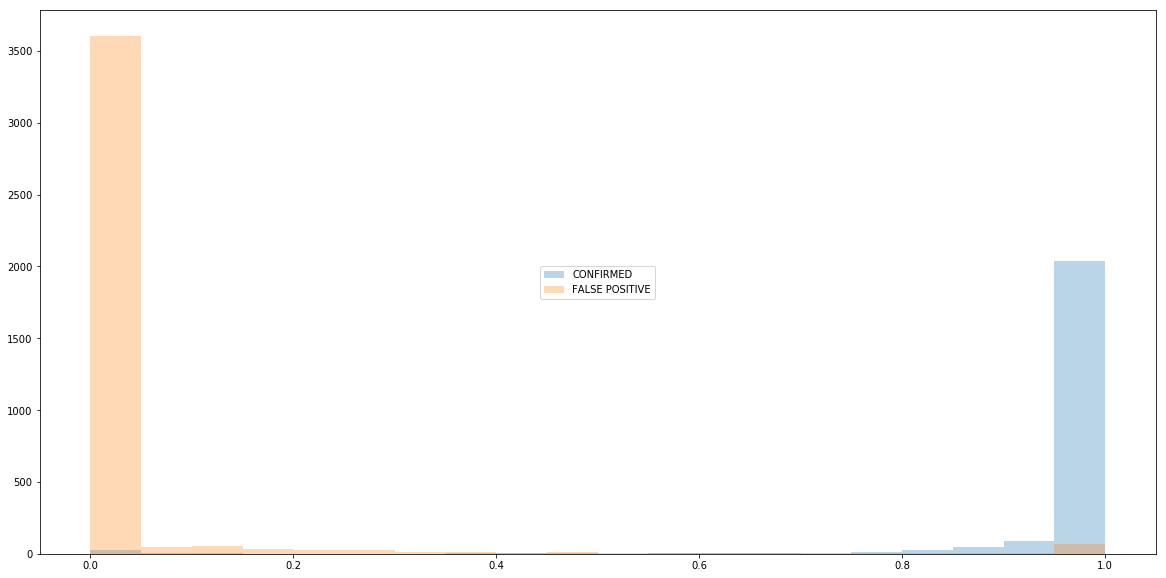

In [51]:
# Checking score distribution depending on the class
score = kepler_tab[kepler_tab.koi_score.notnull()].loc[:,['koi_disposition','koi_score']]
plt.figure(figsize=(20, 10))
plt.hist(score.koi_score[score.koi_disposition=='CONFIRMED'],histtype='stepfilled', alpha=0.3, bins=20,
         label='CONFIRMED')
plt.hist(score.koi_score[score.koi_disposition=='FALSE POSITIVE'],histtype='stepfilled', alpha=0.3, bins=20,
         label='FALSE POSITIVE')
plt.legend(loc='center')
plt.show()

Therefore, we can establish a simple rule for the detection based on the koi_score as follow :
- If koi_score > 0.5, then the koi is a confirmed planet
- Else, then the koi is a false positive

In [52]:
# Here we calculate the koi_score accuracy on the test set
y_pred_koiscore = []
for i in X_test.index:
    if kepler_tab.koi_score[i]>0.5:
        y_pred_koiscore.append('CONFIRMED')
    if kepler_tab.koi_score[i]<=0.5:
        y_pred_koiscore.append('FALSE POSITIVE')
nb_correct=0
#Note that some data points have no koi_score calculated, and will then be removed
y_test_reset = y_test[kepler_tab.koi_score.notnull()].reset_index(drop=True) 
for i in y_test_reset.index:
    if y_test_reset[i]==y_pred_koiscore[i]:
        nb_correct=nb_correct+1
koiscore_accuracy =nb_correct/y_test_reset.shape[0]
print('koi_score Accuracy: {:.4f}'.format(koiscore_accuracy))

koi_score Accuracy: 0.9758


### 4 - Summerizing performance

#### 4-1 All models

##### Accuracy

In [53]:
# Accuracy
accuracy_list = pd.DataFrame({'Model':['Knn Baseline','Decision tree','Random forest','SVM Linear','SVM RBF',
                                       'Logistic regression','koi_score'],
                              'Test accuracy':[knngridcv_accuracy,dtgridcv_accuracy,rf_accuracy,
                                               svmlinear_accuracy,svmrbf_accuracy,lr_accuracy,koiscore_accuracy]})
accuracy_list.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
1,Decision tree,0.990253
4,SVM RBF,0.985380
5,Logistic regression,0.983431
3,SVM Linear,0.982456
2,Random forest,0.980507
6,koi_score,0.975782
0,Knn Baseline,0.953216


All models, except Knn and Most frequent, have similar accuracy, including koi_score

##### Confusion Matrices

In [54]:
# Source of this function : 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)
pass

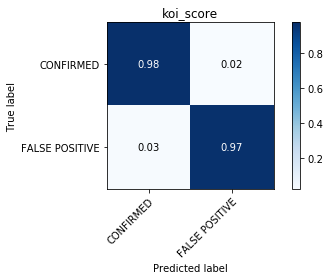

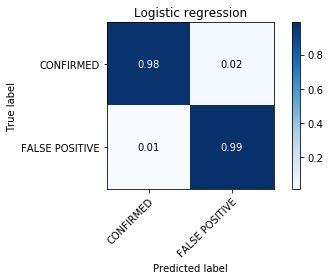

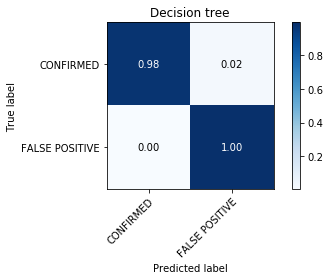

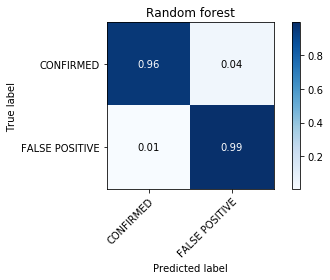

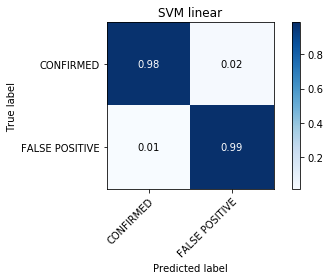

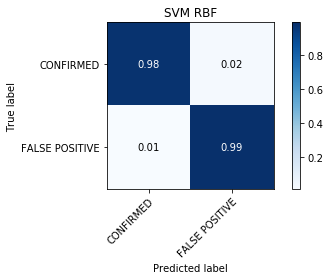

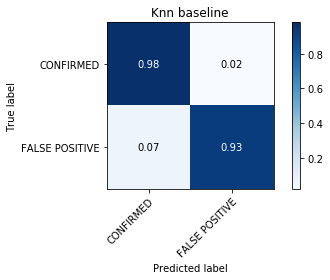

In [55]:
# Confusion Matrices
models = [['Logistic regression',lr_gridcv],
['Decision tree',dt_gridcv],
['Random forest',rf],
['SVM linear',svmlinear_gridcv],
['SVM RBF',svmrbf_gridcv],
['Knn baseline',knn_gridcv]]
from sklearn.metrics import confusion_matrix
y_true = y_test
plot_confusion_matrix(y_test_reset, y_pred_koiscore, classes=['CONFIRMED','FALSE POSITIVE'], title='koi_score')
for i in range(6):
    y_pred = models[i][1].predict(X_test)
    plot_confusion_matrix(y_true, y_pred, classes=['CONFIRMED','FALSE POSITIVE'], title=models[i][0])

All classifiers (except random forest) have the same precision

#### 4-2 koi_score vs Logistic regression

##### Probabilities

The purpose of this part if to check if there is any likelyhood between the probabilities calculated by the logistic regression for the positive event and the koi_score given in the dataset

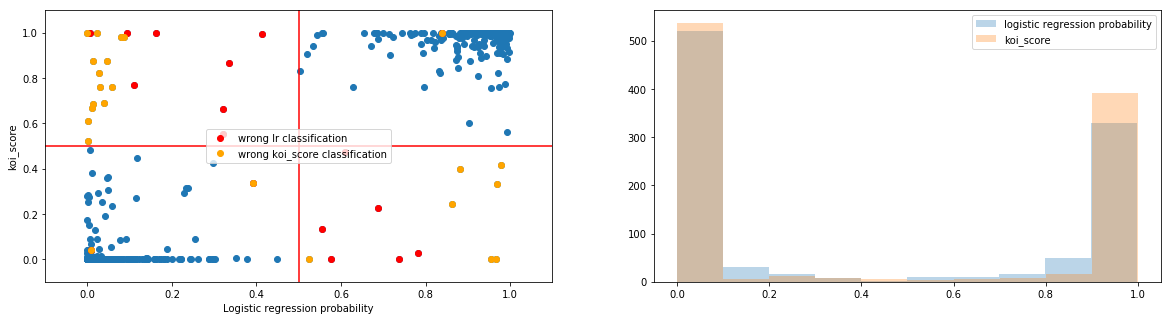

In [56]:
prob = lr_gridcv.predict_proba(X_test[kepler_tab.koi_score.notnull()].values)[:,0]
score = kepler_tab.koi_score[X_test[kepler_tab.koi_score.notnull()].index].values
y_lr_pred = lr_gridcv.predict(X_test[kepler_tab.koi_score.notnull()].values)
f = plt.figure(figsize=(20, 5))

# Plot a scatter of probabilities and koi_score
subplot = f.add_subplot(1,2,1)
plt.scatter(prob,score)
# Plot separately, in a different color, points where logistic regression failed to classify
plt.scatter(prob[~(y_lr_pred == y_test[kepler_tab.koi_score.notnull()])],
            score[~(y_lr_pred == y_test[kepler_tab.koi_score.notnull()])],
            color='red',label='wrong lr classification')
# Plot separately, in a different color, points where koi_score failed to classify
plt.scatter(prob[~(y_pred_koiscore == y_test[kepler_tab.koi_score.notnull()])],
            score[~(y_pred_koiscore == y_test[kepler_tab.koi_score.notnull()])],
            color='orange',label='wrong koi_score classification')
plt.hlines(0.5, -0.1, 1.1,linestyles='solid', color='red')
plt.vlines(0.5, -0.1, 1.1,linestyles='solid', color='red')
plt.xlabel('Logistic regression probability')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.ylabel('koi_score')
plt.legend(loc='center')

# Plot density of each
subplot = f.add_subplot(1,2,2)
plt.hist(prob,histtype='stepfilled', alpha=0.3, bins=10,label='logistic regression probability')
plt.hist(score,histtype='stepfilled', alpha=0.3, bins=10,label='koi_score')
plt.legend()
plt.show()

Observations:

The scatter plot shows the following things :
- The lower left and the upper right areas shows datapoints where both classifiers are aligned on the classification result, which was the correct one for all them (except for 3 of them)
- The upper left and the lower right areas shows datapoints where the 2 classifiers have opposite results, but which also means that one of them is correct.
- The overall picture shows the comlementarity of the two classifiers but that also implies that we cannot really decide which one would be correct if we don't add a third classifier (in order to have an odd number of classifiers for voting that will be different than 50%)

The histogram plots shows another view of how the probability is more spread than the koi_score is (most of the values are either almost 0 or 1)

##### ROC Curves

The purpose here is to compare performance of these 2 classifiers using ROC curves

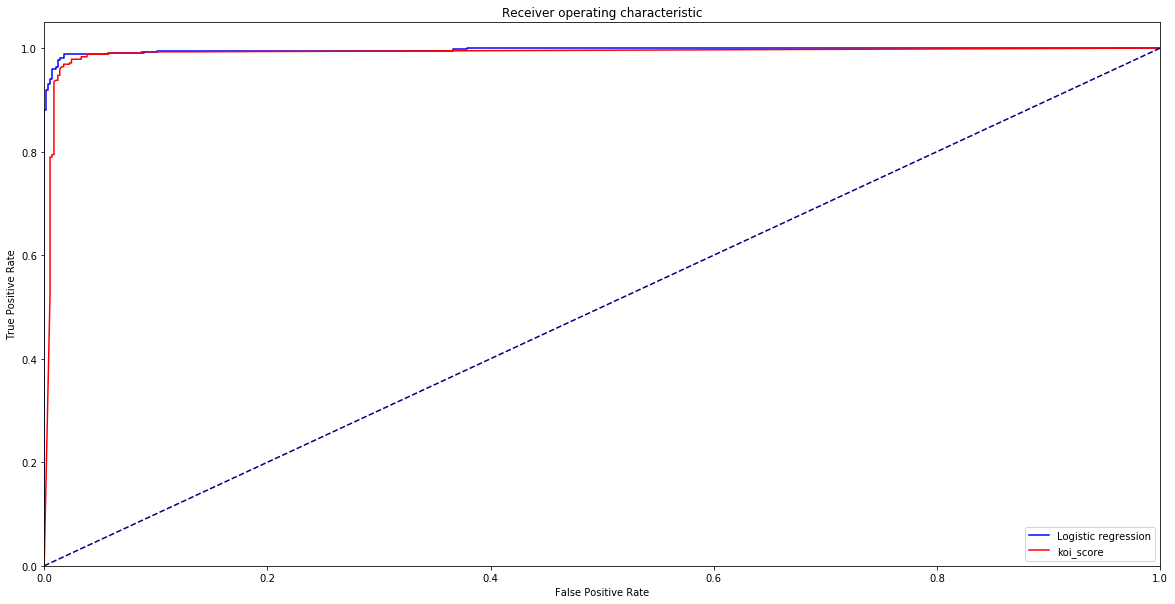

In [57]:
from sklearn import metrics
y_true = y_test[kepler_tab.koi_score.notnull()]
fpr_lr, tpr_lr, thr_lr = metrics.roc_curve(y_true, prob, pos_label='CONFIRMED')
fpr_koiscore, tpr_koiscore, thr_koiscore = metrics.roc_curve(y_true, score, pos_label='CONFIRMED')
plt.figure(figsize=(20,10))
plt.plot(fpr_lr, tpr_lr,color='blue',label='Logistic regression')
plt.plot(fpr_koiscore, tpr_koiscore,color='red',label='koi_score')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend()
plt.show()

 Both classifiers have a good performance but Logistic regression's one is slightly better as its curve is closer to the top-left corner

### 5 - Prediction set

#### 5-1 Creating an ensemble classifier

We are creating here an ensemble classifier by combining 5 of the 7 classifiers in a Voting classifier. We are not considering here the koi_score as it's not using the same features than the others, and the knn as it's the baseline.

In [58]:
%%time
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators=[('Logistic regression',lr_gridcv), ('Random forest',rf), ('Decision tree',dt_gridcv), 
                                     ('SVM linear',svmlinear_gridcv), ('SVM RBF',svmrbf_gridcv)], voting='hard')
voting.fit(X_train,y_train)
voting_accuracy = voting.score(X_test,y_test)
print('Voting classifier accuracy (test set): {:.4f}'.format(voting_accuracy))

Voting classifier accuracy (test set): 0.9844
Wall time: 7min 45s


C:\Users\dridi\Anaconda3\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### 5-2 Applying, separately, all classifiers to the prediction set

C:\Users\dridi\Anaconda3\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Voting {'CONFIRMED': 1328, 'FALSE POSITIVE': 421}
Logistic regression {'CONFIRMED': 1238, 'FALSE POSITIVE': 511}
Decision tree {'CONFIRMED': 1614, 'FALSE POSITIVE': 135}
Random forest {'CONFIRMED': 1079, 'FALSE POSITIVE': 670}
SVM Linear {'CONFIRMED': 1343, 'FALSE POSITIVE': 406}
SVM RBF {'CONFIRMED': 1319, 'FALSE POSITIVE': 430}
Knn {'CONFIRMED': 1362, 'FALSE POSITIVE': 387}
koi_score {'CONFIRMED': 1573, 'FALSE POSITIVE': 247}


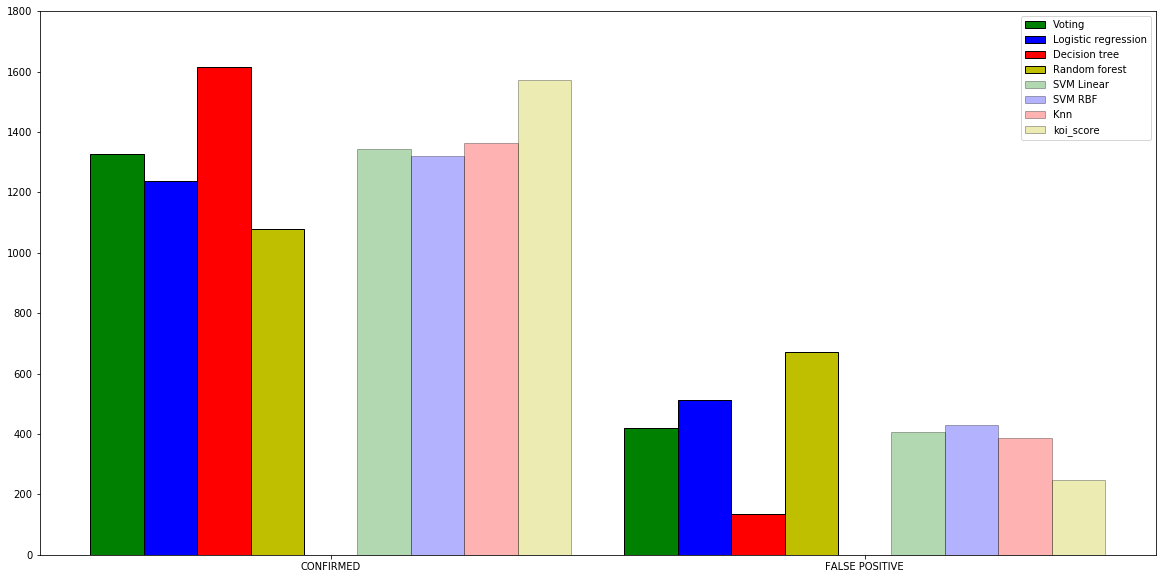

In [59]:
# Select the input
X_pred = kepler_tab[(kepler_tab.koi_disposition == 'CANDIDATE')].drop(to_drop,axis=1)
X_pred_nn = X_pred[X_pred.isnull().sum(axis=1)==0]
# The input for the koi_score classifier is different, as using different features
X_koiscore = kepler_tab[(kepler_tab.koi_disposition == 'CANDIDATE')&(kepler_tab.koi_score.notnull())].drop(to_drop,axis=1)

# Prediction for each classifier
y_pred_lr = lr_gridcv.predict(X_pred_nn)
y_pred_dt = dt_gridcv.predict(X_pred_nn)
y_pred_rf = rf.predict(X_pred_nn)
y_pred_svmlinear = svmlinear_gridcv.predict(X_pred_nn)
y_pred_svmrbf = svmrbf_gridcv.predict(X_pred_nn)
y_pred_knn = knn_gridcv.predict(X_pred_nn)
y_pred_koiscore = []
for i in X_koiscore.index:
    if kepler_tab.koi_score[i]>0.5:
        y_pred_koiscore.append('CONFIRMED')
    if kepler_tab.koi_score[i]<=0.5:
        y_pred_koiscore.append('FALSE POSITIVE')
y_pred_voting = voting.predict(X_pred_nn)

# Show results
index=np.array([0,1])
plt.figure(figsize=(20,10))
unique, counts = np.unique(y_pred_voting, return_counts=True)
plt.bar(index-0.4, counts, width=0.1, color='g', edgecolor='black',label='Voting')
print('Voting',dict(zip(unique, counts)))
unique, counts = np.unique(y_pred_lr, return_counts=True)
plt.bar(index-0.3, counts, width=0.1, color='b', edgecolor='black',label='Logistic regression')
print('Logistic regression',dict(zip(unique, counts)))
unique, counts = np.unique(y_pred_dt, return_counts=True)
plt.bar(index-0.2, counts, width=0.1, color='r', edgecolor='black',label='Decision tree')
print('Decision tree',dict(zip(unique, counts)))
unique, counts = np.unique(y_pred_rf, return_counts=True)
plt.bar(index-0.1, counts, width=0.1, color='y', edgecolor='black',label='Random forest')
print('Random forest',dict(zip(unique, counts)))
unique, counts = np.unique(y_pred_svmlinear, return_counts=True)
plt.bar(index+0.1, counts, width=0.1, color='g', edgecolor='black',label='SVM Linear',alpha=0.3)
print('SVM Linear',dict(zip(unique, counts)))
unique, counts = np.unique(y_pred_svmrbf, return_counts=True)
plt.bar(index+0.2, counts, width=0.1, color='b', edgecolor='black',label='SVM RBF',alpha=0.3)
print('SVM RBF',dict(zip(unique, counts)))
unique, counts = np.unique(y_pred_knn, return_counts=True)
plt.bar(index+0.3, counts, width=0.1, color='r', edgecolor='black',label='Knn',alpha=0.3)
print('Knn',dict(zip(unique, counts)))
unique, counts = np.unique(y_pred_koiscore, return_counts=True)
plt.bar(index+0.4, counts, width=0.1, color='y', edgecolor='black',label='koi_score',alpha=0.3)
print('koi_score',dict(zip(unique, counts)))
plt.bar(index, [0,0],tick_label=unique,align='center')
plt.ylim(top=1800)
plt.legend()
plt.show()

This warning is obviously due to a bug in the sklearn version I'm using. It's corrected in later version :
https://stackoverflow.com/questions/49545947/sklearn-deprecationwarning-truth-value-of-an-array?noredirect=1&lq=1

Something interesting to notice in this figure/prediction results is that even all classifiers' accuracy (except the knn baselin) is close to each other, decision tree and random forest are giving results quite far from the others

In [60]:
# Check of the versions
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
import numpy
print('The numpy version is {}.'.format(numpy.version.version))

The scikit-learn version is 0.19.0.
The numpy version is 1.15.4.


In [61]:
# Let's create the prediction output file
output = pd.DataFrame({'Name':kepler_tab.kepoi_name[X_pred_nn.index].values,'Result':y_pred_voting})
output.to_csv('Detection output.csv', index=False)
output.head()

,Name,Result
0,K00753.01,CONFIRMED
1,K00760.01,CONFIRMED
2,K00777.01,CONFIRMED
3,K00780.02,FALSE POSITIVE
4,K00115.03,CONFIRMED
